In [8]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
import sys

import pandas as pd
import numpy as np
from pathlib import Path
import yaml
from typing import *
import glob

import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
import matplotlib
import matplotlib.pyplot as plt

import pyspark
import pyspark.sql.functions as F
from pyspark.sql import SparkSession, DataFrame, Window
import itertools

from saturation.utils import *

pio.renderers.default = "iframe"

In [10]:
n_cores = 28

spark = (SparkSession.builder
         .master(f"local[{n_cores}]")
         .appName("Saturation")
         .config("spark.sql.shuffle.partitions", "500")
         .config("spark.driver.memory", "30g")
         .config("spark.driver.maxResultSize", "8g")
         .getOrCreate())

In [11]:
base_path = "/data/saturation/thesis_run_20250223/"

configs_pdf, configs_df, configs_dict = get_configs(
    base_path=base_path,
    spark=spark,
)

25/02/23 08:26:20 WARN CacheManager: Asked to cache already cached data.


## Example CSFD

In [21]:
simulation_id = 161
b_p = configs_dict[simulation_id]["slope"]
young_target_nstat = 5e2
older_target_nstat = 3e4
oldest_target_nstat = int(2.5e6)

r_stat = configs_dict[simulation_id]["rstat"]
study_region_size = configs_dict[simulation_id]["study_region_size"]
study_region_padding = configs_dict[simulation_id]["study_region_padding"]

sim_name = simulation_id
sim_path = f"{base_path}/{sim_name}"

stats_df = spark.read.parquet(f"{sim_path}/statistics_*.parquet")
craters_df = spark.read.parquet(f"{sim_path}/craters_*.parquet")
removals_df = spark.read.parquet(f"{sim_path}/crater_removals_*.parquet")

young_state = get_state_at_time(
    stats_df=stats_df,
    craters_df=craters_df,
    removals_df=removals_df,
    simulation_id=simulation_id,
    target_nstat=young_target_nstat,
    study_region_size=study_region_size,
    study_region_padding=study_region_padding,
    spark=spark

)

older_state = get_state_at_time(
    stats_df=stats_df,
    craters_df=craters_df,
    removals_df=removals_df,
    simulation_id=simulation_id,
    target_nstat=older_target_nstat,
    study_region_size=study_region_size,
    study_region_padding=study_region_padding,
    spark=spark
)

oldest_state = get_state_at_time(
    stats_df=stats_df,
    craters_df=craters_df,
    removals_df=removals_df,
    simulation_id=simulation_id,
    target_nstat=oldest_target_nstat,
    study_region_size=study_region_size,
    study_region_padding=study_region_padding,
    spark=spark
)   

In [22]:
oldest_state.describe()

,x,y,radius
count,261.000000,261.000000,261.000000
mean,751.047857,738.171474,4.142715
std,355.711650,341.250712,1.352108
min,153.281404,150.535602,3.002722
25%,446.817690,439.152654,3.313376
50%,791.311809,756.334168,3.653819
75%,1065.221132,1030.219767,4.487235
max,1349.118230,1347.269219,12.912515


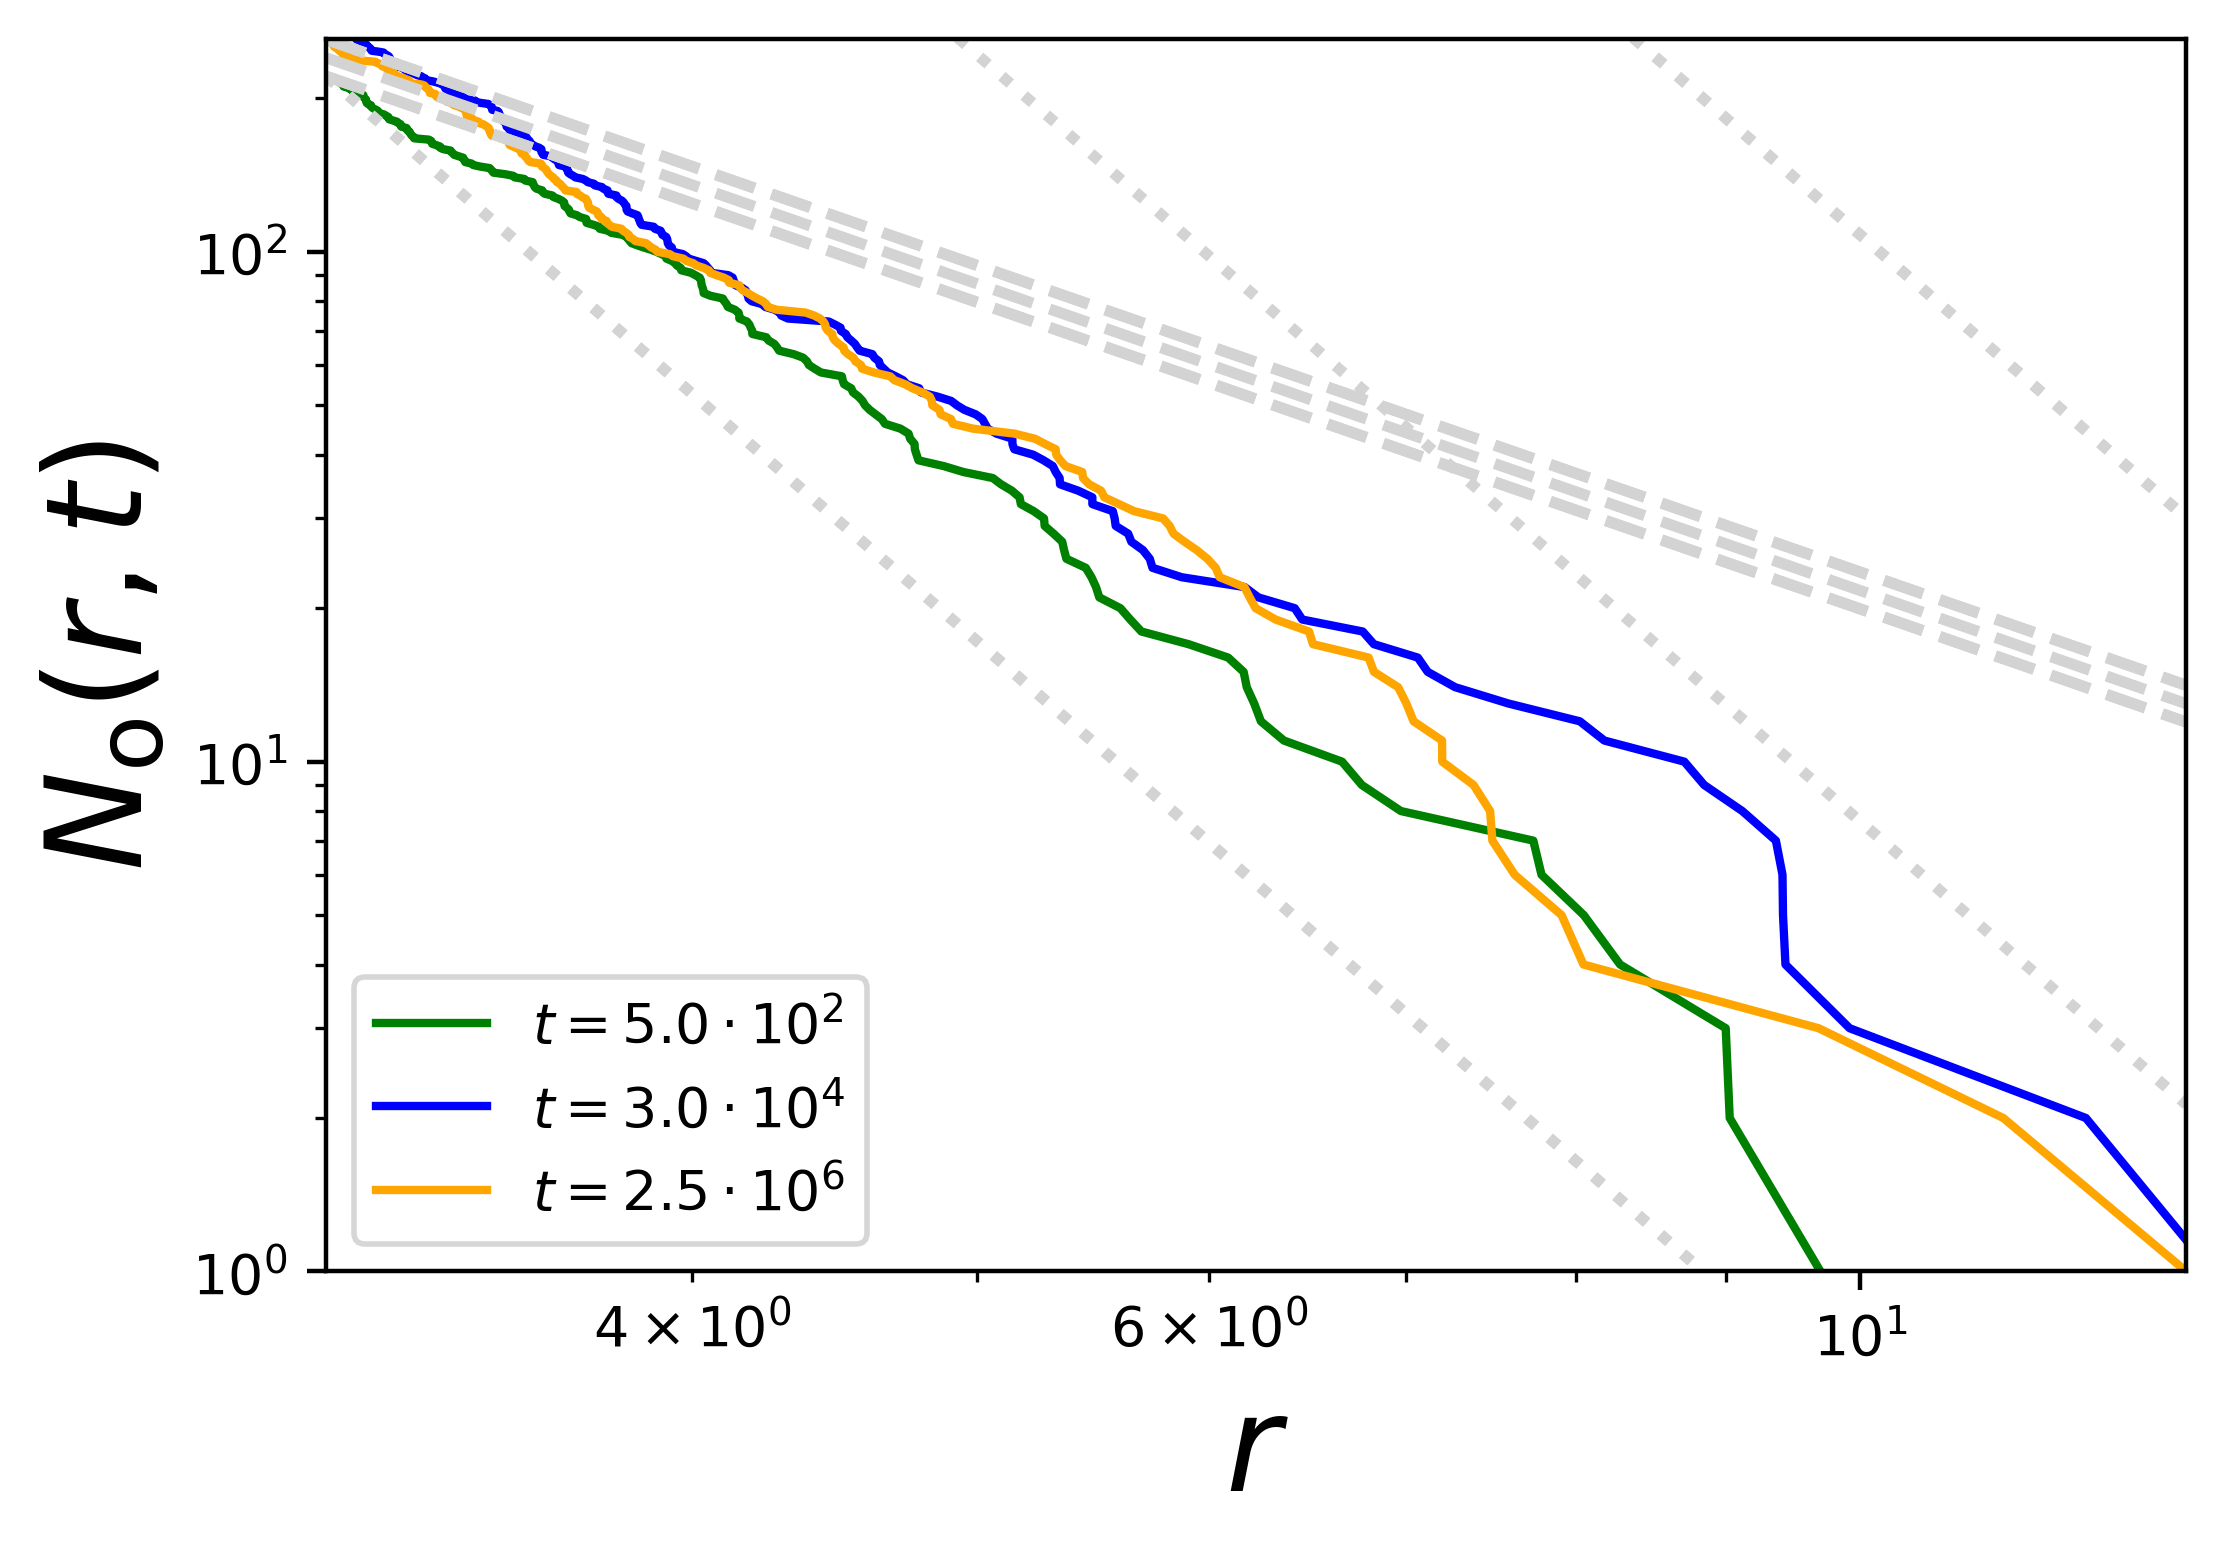

25/02/23 08:28:04 WARN JavaUtils: Attempt to delete using native Unix OS command failed for path = /tmp/blockmgr-432cca7c-3665-40b8-9ba4-9f98048f3cf2. Falling back to Java IO way
java.io.IOException: Failed to delete: /tmp/blockmgr-432cca7c-3665-40b8-9ba4-9f98048f3cf2
	at org.apache.spark.network.util.JavaUtils.deleteRecursivelyUsingUnixNative(JavaUtils.java:173)
	at org.apache.spark.network.util.JavaUtils.deleteRecursively(JavaUtils.java:109)
	at org.apache.spark.network.util.JavaUtils.deleteRecursively(JavaUtils.java:90)
	at org.apache.spark.util.SparkFileUtils.deleteRecursively(SparkFileUtils.scala:121)
	at org.apache.spark.util.SparkFileUtils.deleteRecursively$(SparkFileUtils.scala:120)
	at org.apache.spark.util.Utils$.deleteRecursively(Utils.scala:1126)
	at org.apache.spark.storage.DiskBlockManager.$anonfun$doStop$1(DiskBlockManager.scala:368)
	at org.apache.spark.storage.DiskBlockManager.$anonfun$doStop$1$adapted(DiskBlockManager.scala:364)
	at scala.collection.IndexedSeqOptimize

In [23]:
font_size = 24
n_lines_below = 0
n_lines_above = 0
n_geometric_saturation_ref_lines = 3
n_production_ref_lines = 3

young_radii = young_state.radius.sort_values()
older_radii = older_state.radius.sort_values()
oldest_radii = oldest_state.radius.sort_values()
nobs_young = young_radii.count()
nobs_old = oldest_radii.count()
min_r_ref = oldest_radii.min()

fig = plt.figure(figsize=(6, 4), dpi=400)
ax = fig.add_subplot(111)

# Plot young state
observed_young_y = range(len(young_radii), 0, -1)
ax.plot(young_radii, observed_young_y, label=f"$t={get_scientific_notation(young_target_nstat, 1)}$", color="green")

# Plot older state
observed_older_y = range(len(older_radii), 0, -1)
ax.plot(older_radii, observed_older_y, label=f"$t={get_scientific_notation(older_target_nstat, 1)}$", color="blue")

# Plot old state
observed_oldest_y = range(len(oldest_radii), 0, -1)
ax.plot(oldest_radii, observed_oldest_y, label=f"$t={get_scientific_notation(oldest_target_nstat, 1)}$", color="orange")

# Add multiple reference lines for each slope
x_ref = np.logspace(np.log10(oldest_radii.min()), np.log10(oldest_radii.max()), 100)

young_geometric_saturation_intercept = nobs_young / min_r_ref ** -2
young_production_intercept = nobs_young / min_r_ref ** b_p

old_geometric_saturation_intercept = nobs_old / min_r_ref ** -2
old_production_intercept = nobs_old / min_r_ref ** b_p

intercepts = np.logspace(
    start=np.log10(young_geometric_saturation_intercept),
    stop=np.log10(old_geometric_saturation_intercept),
    num=n_geometric_saturation_ref_lines
)
step_size = intercepts[1] / intercepts[0]
geometric_saturation_intercepts = [
    *[intercepts[0] / step_size**x for x in range(n_lines_below + 1)],
    *intercepts,
    *[intercepts[-1] * step_size**x for x in range(n_lines_above + 1)]
]

intercepts = np.logspace(
    start=np.log10(young_production_intercept),
    stop=np.log10(young_production_intercept * 200),
    num=n_geometric_saturation_ref_lines
)
step_size = intercepts[1] / intercepts[0]
production_intercepts = [
    *[intercepts[0] / step_size**x for x in range(n_lines_below + 1)],
    *intercepts,
    *[intercepts[-1] * step_size**x for x in range(n_lines_above + 1)]
]

reference_lines = {
    -2: {
        "intercepts": geometric_saturation_intercepts,
        "style": "dashed"
    },
    b_p: {
        "intercepts": production_intercepts,
        "style": "dotted"
    }
}

for b_ref, params in reference_lines.items():
    for intercept in params["intercepts"]:
        y_ref = intercept * x_ref**b_ref
        ax.plot(x_ref, y_ref,ls=params["style"], color="lightgray", lw="2")

# Set limits based on observed data
ax.set_xlim(oldest_radii.min(), oldest_radii.max())
ax.set_ylim(min(observed_oldest_y), max(observed_oldest_y))

# Labels and scaling
ax.set_xlabel("$r$", fontsize=font_size)
ax.set_ylabel("$N_{\\text{o}}(r, t)$", fontsize=font_size)

ax.set_xscale("log")
ax.set_yscale("log")
ax.legend()

plt.savefig("figures/example_csfds.png", bbox_inches="tight")

plt.show()